In [0]:
%pip
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.functions import vector_to_array

In [0]:
# dbutils.fs.rm("dbfs:/FileStore/tables/mth_rolling_features.csv")


True

#1.1 Import the monthly and annual data and join

In [0]:
# import data 
annual_feature = spark.read.format("csv").option("header", 
                                      "true").load("dbfs:/FileStore/tables/annual_features.csv")
annual_day_of_week_counts_pivot = spark.read.format("csv").option("header","true").load("dbfs:/FileStore/tables/annual_day_of_week_counts_pivot.csv")
days_since_last_txn = spark.read.format("csv").option("header",
                                      "true").load("dbfs:/FileStore/tables/days_since_last_txn.csv")
mth_day_counts = spark.read.format("csv").option("header", 
                                      "true").load("dbfs:/FileStore/tables/mth_day_counts.csv")
mth_rolling_features = spark.read.format("csv").option("header","true").load("dbfs:/FileStore/tables/mth_rolling_features.csv")
retail_data_response = spark.read.format("csv").option("header",
                                      "true").load("dbfs:/FileStore/tables/Retail_Data_Response.csv")

In [0]:
# join annual features 
annual_features = annual_feature.join(annual_day_of_week_counts_pivot,on = "customer_id",how = "left")
annual_features = annual_features.join(retail_data_response,on = "customer_id", how = "left")
annual_features = annual_features.dropna()

In [0]:
# join monthly features 
mth_day_counts = mth_day_counts.withColumnRenamed("customer_id", "CLNT_NO")
mth_features = mth_rolling_features.join(mth_day_counts,on=["CLNT_NO","ME_DT"],how="left")
mth_features = mth_features.join(days_since_last_txn,on=["CLNT_NO","ME_DT"],how="left")
mth_features = mth_features.join(retail_data_response, mth_features["CLNT_NO"]==retail_data_response["customer_id"],how="left")
mth_features = mth_features.drop("customer_id")
mth_features = mth_features.dropna()

#1.2 Classification Methods

Steps:
1. Separate the inputs X and the output y in two data frames.
2. Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency 
3. Pre-process data.
4. Fit the training dataset and optimize the hyperparameters of the method.
5. Plot coefficient values or feature importance.
6. Plot probability distribution for test set.
7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.


Data Preperation 1: Cast feature type to Double

In [0]:
# Annual Data
annual_features = annual_features.drop("customer_id")
annual_features = annual_features.select([col(c).cast(DoubleType()) for c in annual_features.columns])
annual_features = annual_features.fillna(0)
 
# Monthly Data
mth_features = mth_features.drop("CLNT_NO","ME_DT")
mth_features = mth_features.select([col(c).cast(DoubleType()) for c in mth_features.columns])
mth_features = mth_features.fillna(0)

Data Preperation 2: Split data into test-train datasets

Use a test size value of 2/3 and set the random state equal to 1147 for consistency

In [0]:
# Annual Data
train_annual, test_annual = annual_features.randomSplit([1/3, 2/3], seed=1147)
x_annual_colnames = annual_features.columns
y_train_annual = train_annual.select('response')
y_test_annual = test_annual.select('response')
x_annual_colnames.pop(-1)
 
# Monthly Data
train_monthly, test_monthly = mth_features.randomSplit([1/3, 2/3], seed=1147)
x_mth_colnames = mth_features.columns
y_train_monthly = train_monthly.select('response')
y_test_monthly = test_monthly.select('response')
x_mth_colnames.pop(-1)

'cnt_Tuesday'

Data Preperation 3: Vectorization

In [0]:
# Annual Data
vecAssembler = VectorAssembler(inputCols=x_annual_colnames,outputCol="features")
vecX_train_annual = vecAssembler.transform(train_annual)
vecX_test_annual = vecAssembler.transform(test_annual)

In [0]:
# Monthly Data
vecAssembler = VectorAssembler(inputCols=x_mth_colnames,outputCol="features")
vecX_train_monthly = vecAssembler.transform(train_monthly)
vecX_test_monthly = vecAssembler.transform(test_monthly)

Data Preperation 4: Standardization

In [0]:
# Annual Data 
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_ann = scaler.fit(vecTrain_annual.select("features"))
X_train_annual = scaler_ann.transform(vecX_train_annual)
X_test_annual = scaler_ann.transform(vecX_test_annual)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_mon = scaler.fit(vecTrain_monthly.select("features"))
X_test_monthly = scaler_mon.transform(vecX_train_monthly)
X_train_monthly = scaler_mon.transform(vecX_test_monthly)

Unexpected internal error while constructing `DatabricksConfig` from REPL context: name 'get_ipython' is not defined


##1.2.1 Logistic Regression with L1 Regulizer (Annual Data)


#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Logistic Regression model setup
logReg = LogisticRegression(featuresCol="scaled_features", labelCol='response', maxIter=10, elasticNetParam=1)

# Logistic Regression ParamGrid setup
paramGridLogReg = ParamGridBuilder().addGrid(logReg.regParam, [0.01, 0.55, 0.1]).build()

# Logistic Regression CrossValidator setup
cvLogReg = CrossValidator(
    estimator=logReg,
    estimatorParamMaps=paramGridLogReg,
    evaluator=BinaryClassificationEvaluator(labelCol="response"),
    numFolds=5,
    seed=1147
)

# Fit model, predict, and get best model for Logistic Regression
modelLogReg = cvLogReg.fit(X_train_annual)
predTrainLogReg = modelLogReg.transform(X_train_annual)
predTestLogReg = modelLogReg.transform(X_test_annual)
bestModelLogReg = modelLogReg.bestModel

# Print best regularization parameter for Logistic Regression
print('Best Param (regParam):', bestModelLogReg._java_obj.getRegParam())

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Param (regParam): 0.01


#####Feature Importance

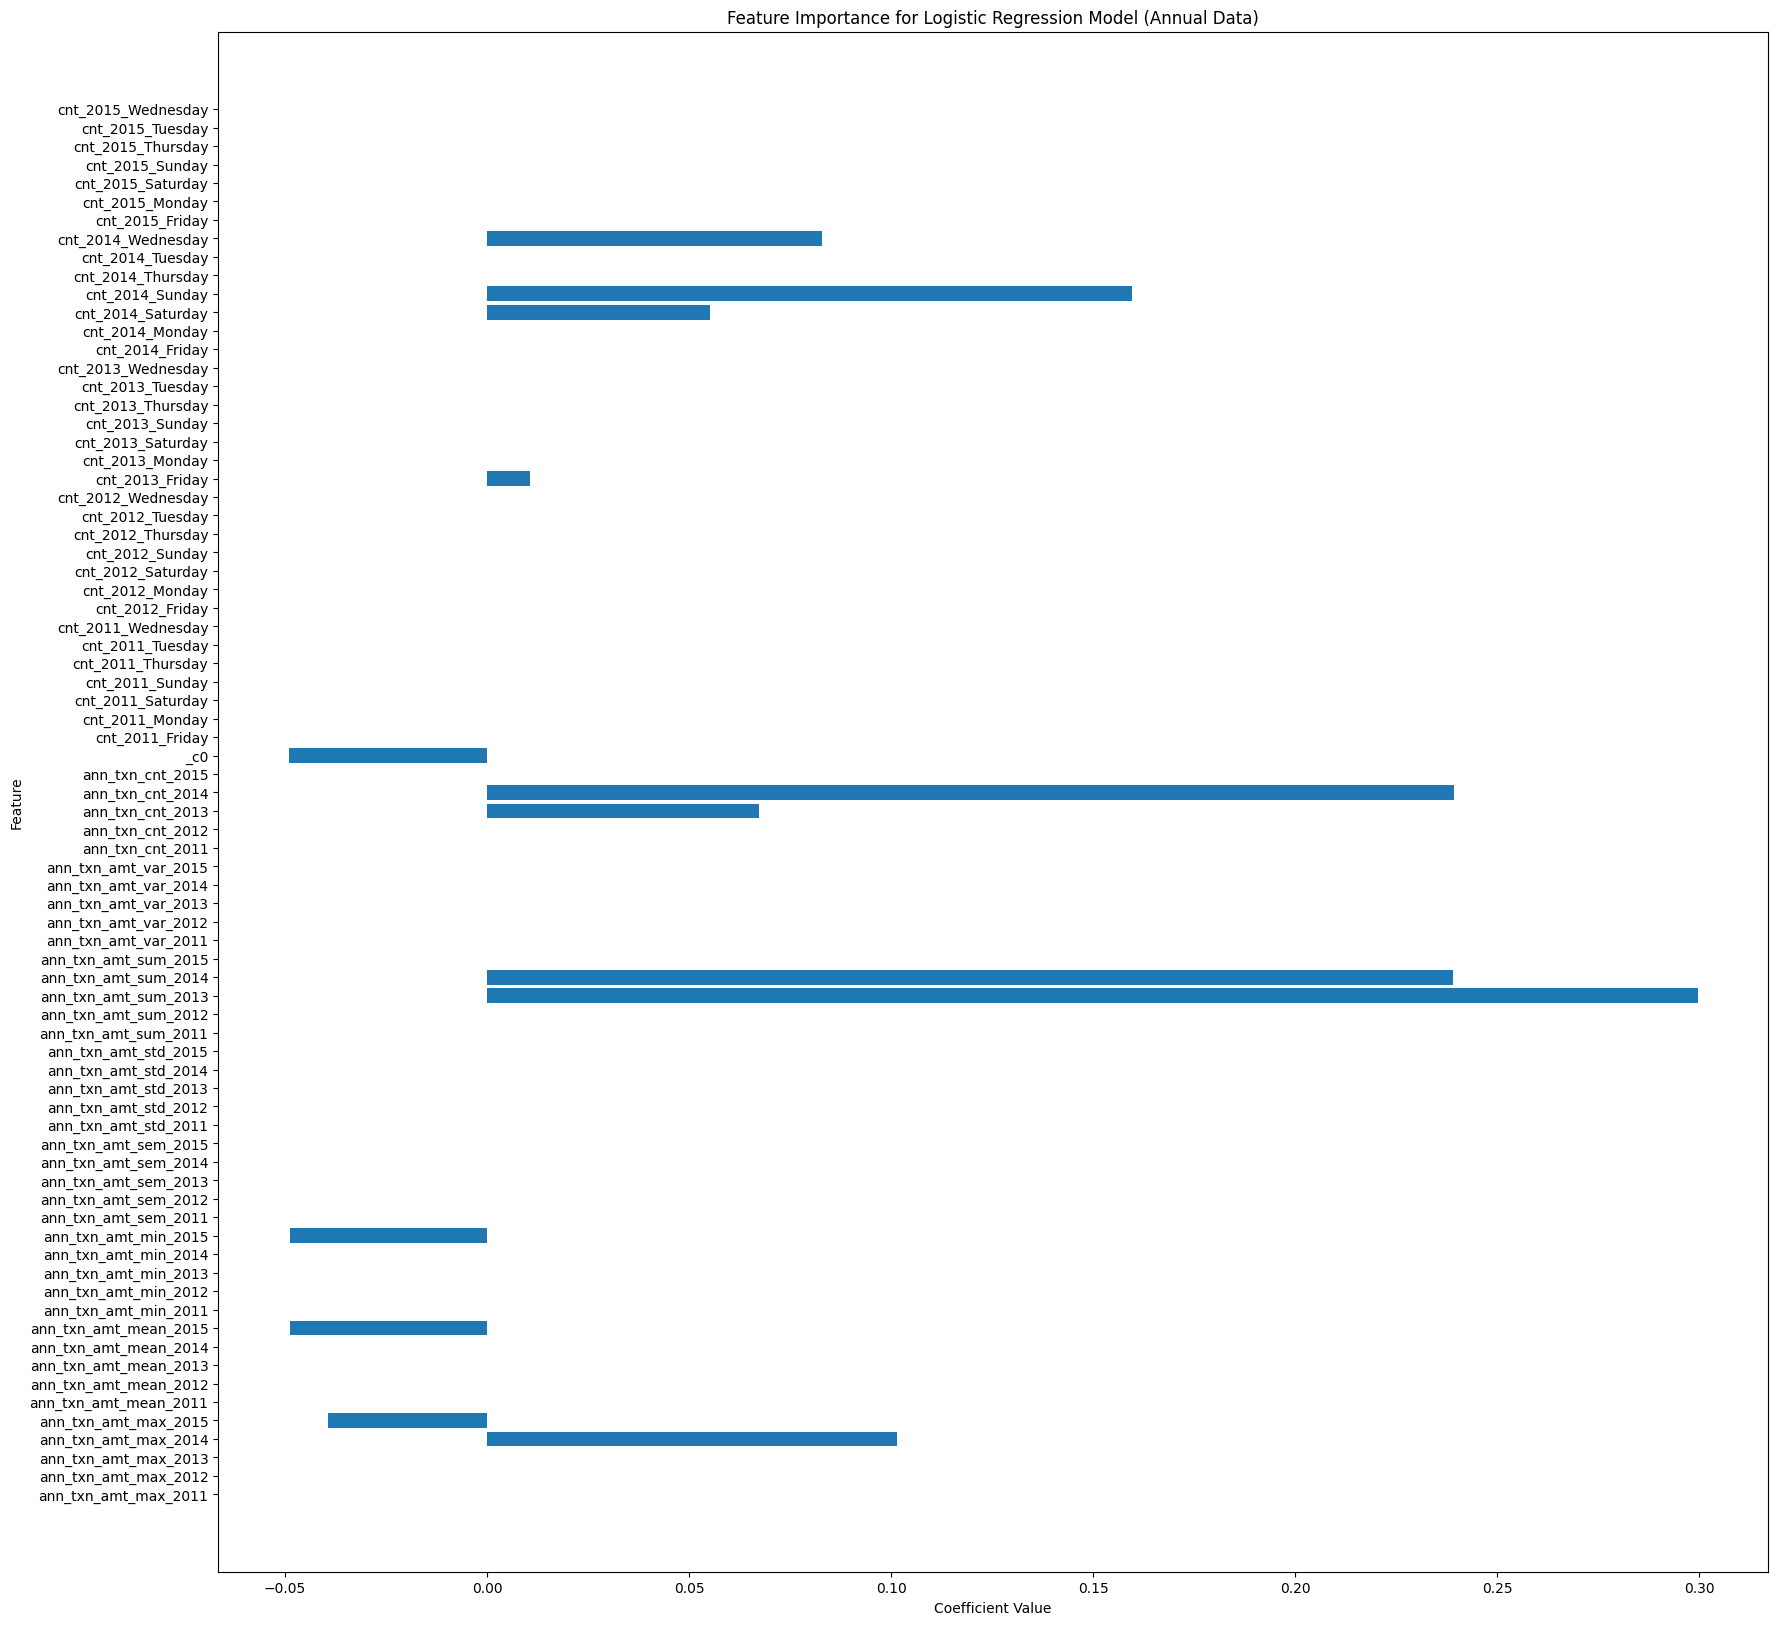

In [0]:
import matplotlib.pyplot as plt

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModelLogReg.coefficients.toArray()

# Plotting feature importance
plt.figure(figsize=(20,20))
plt.barh(x_annual_colnames, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression Model (Annual Data)')
plt.show()

#####probability distribution for test set

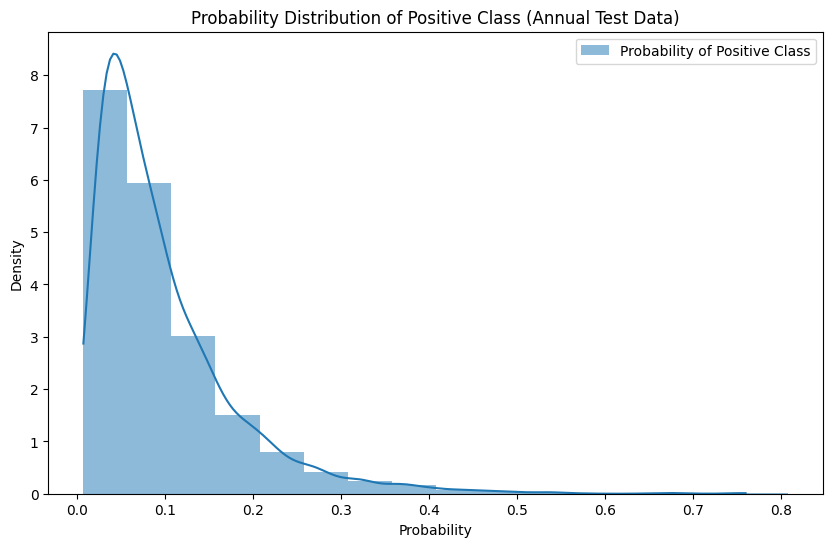

In [0]:
# plot probability distribution for test set

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract probabilities for the positive class
probabilities = predTestLogReg.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Annual Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


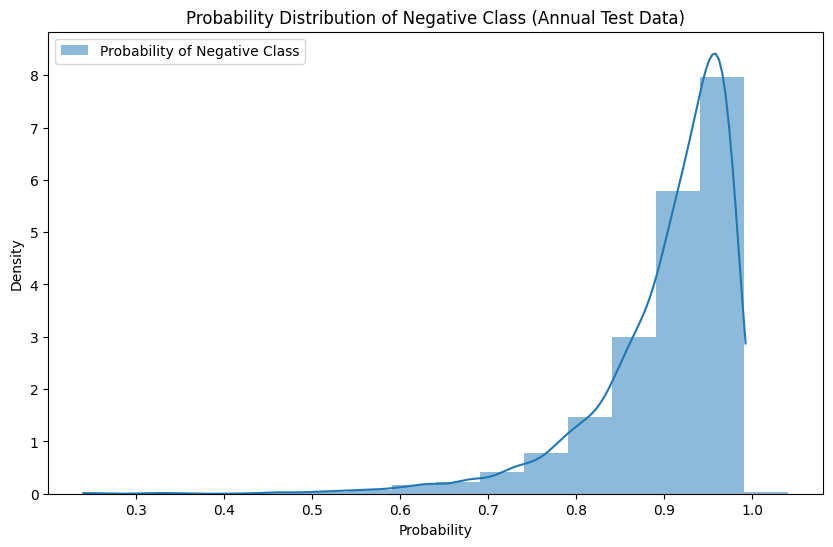

In [0]:
# Extract probabilities for the positive class
probabilities = predTestLogReg.select("probability").rdd.map(lambda row: row[0][0]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Negative Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Negative Class (Annual Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()

#####Confusion Matrix 


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


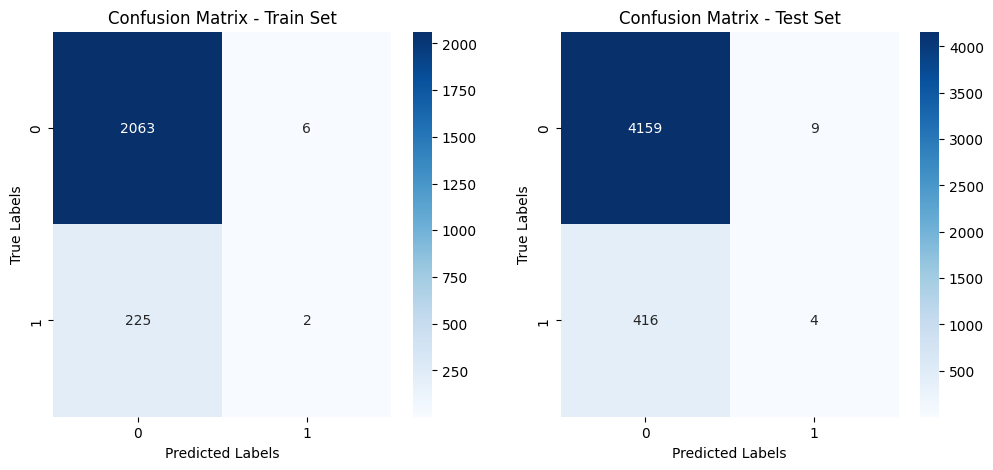

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction and labels to RDD
predictionAndLabels_train = predTrainLogReg.select("prediction", "response").rdd
predictionAndLabels_test = predTestLogReg.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix - Test Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()


#####ROC curve and AUC


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrainLogReg)
auc_test = evaluator.evaluate(predTestLogReg)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

Train Set AUC: 0.7993146149473049
Test Set AUC: 0.7687300063979564


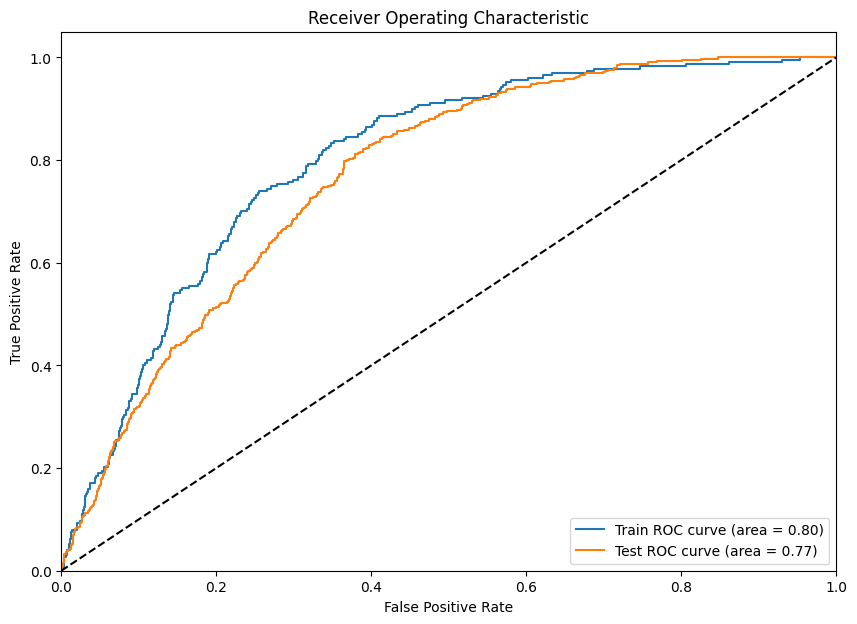

In [0]:
from pyspark.sql.functions import col, lit
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrainLogReg.select("probability", "response").toPandas()
pdPredTest = predTestLogReg.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#####Precision and Recall

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train
predictionAndLabels_train = predTrainLogReg.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTestLogReg.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")


Training Precision: 0.8372326987037353
Training Recall: 0.899390243902439
Test Precision: 0.8540189312690635
Test Recall: 0.9073670444638187


##1.2.2 Logistic Regression with L1 Regulizer (Monthly Data)

#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Logistic Regression model setup
logReg = LogisticRegression(featuresCol="scaled_features", labelCol='response', maxIter=10, elasticNetParam=1)

# Logistic Regression ParamGrid setup
paramGridLogReg = ParamGridBuilder().addGrid(logReg.regParam, [0.001, 0.055, 0.01,0.1]).build()

# Logistic Regression CrossValidator setup
cvLogReg = CrossValidator(
    estimator=logReg,
    estimatorParamMaps=paramGridLogReg,
    evaluator=BinaryClassificationEvaluator(labelCol="response"),
    numFolds=5,
    seed=1147
)

# Fit model, predict, and get best model for Logistic Regression
modelLogRegMon = cvLogReg.fit(X_train_monthly)
predTrainLogRegMon = modelLogRegMon.transform(X_train_monthly)
predTestLogRegMon = modelLogRegMon.transform(X_test_monthly)
bestModelLogRegMon = modelLogRegMon.bestModel

# Print best regularization parameter for Logistic Regression
print('Best Param (regParam):', bestModelLogRegMon._java_obj.getRegParam())

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Param (regParam): 0.001


#####Feature Importance

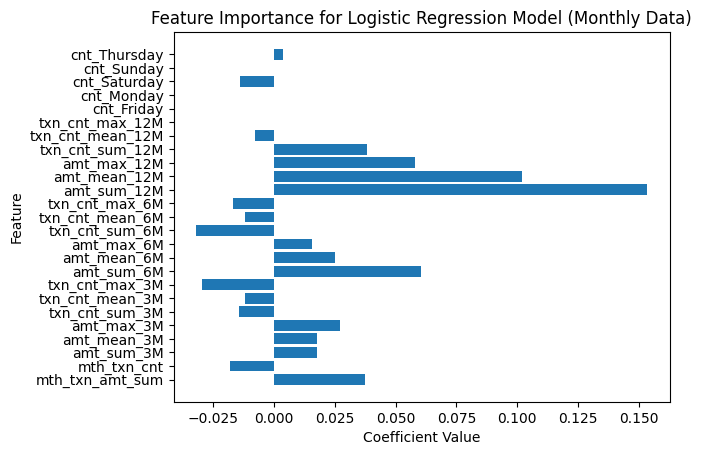

In [0]:
import matplotlib.pyplot as plt

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModelLogRegMon.coefficients.toArray()

# Plotting feature importance
plt.barh(x_mth_colnames, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression Model (Monthly Data)')
plt.show()

#####probability distribution for test set

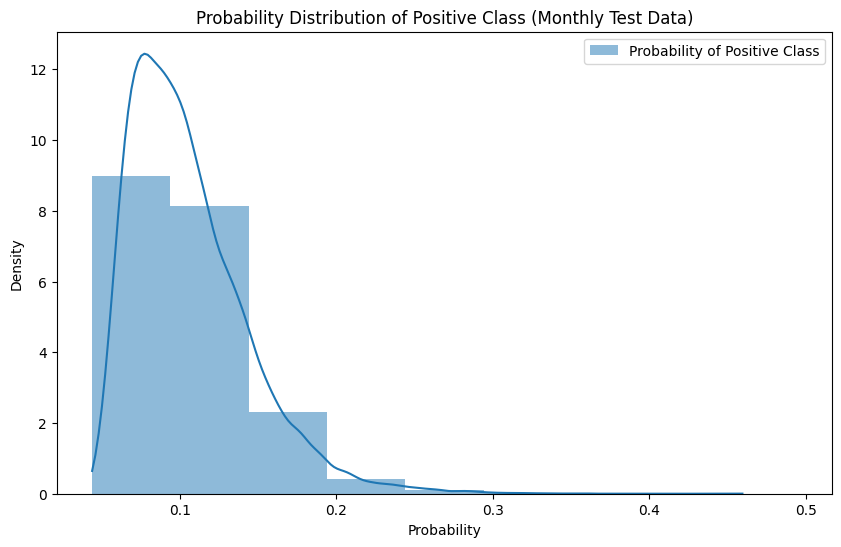

In [0]:
# plot probability distribution for test set

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract probabilities for the positive class
probabilities = predTestLogRegMon.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Monthly Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


#####Confusion Matrix 


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


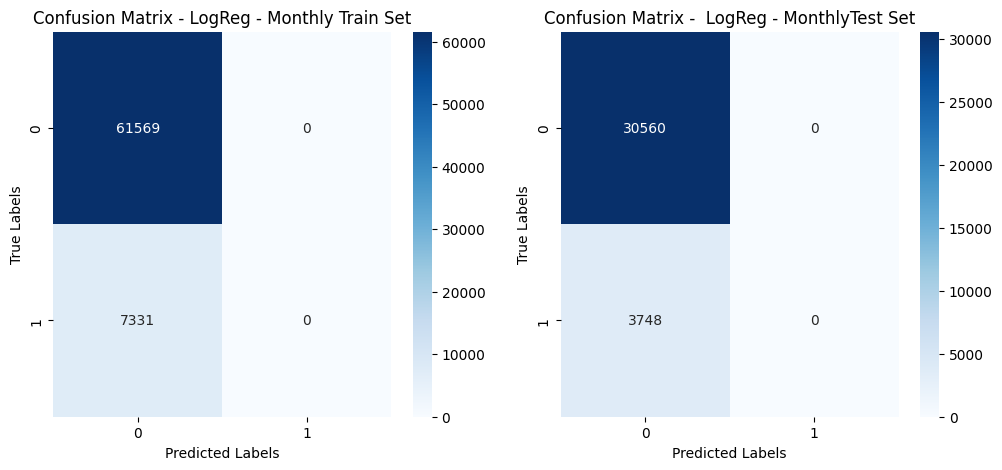

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction and labels to RDD
predictionAndLabels_train = predTrainLogRegMon.select("prediction", "response").rdd
predictionAndLabels_test = predTestLogRegMon.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - LogReg - Monthly Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix -  LogReg - MonthlyTest Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()


#####ROC curve and AUC


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrainLogRegMon)
auc_test = evaluator.evaluate(predTestLogRegMon)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

Train Set AUC: 0.6210527114890726
Test Set AUC: 0.6188335917026603


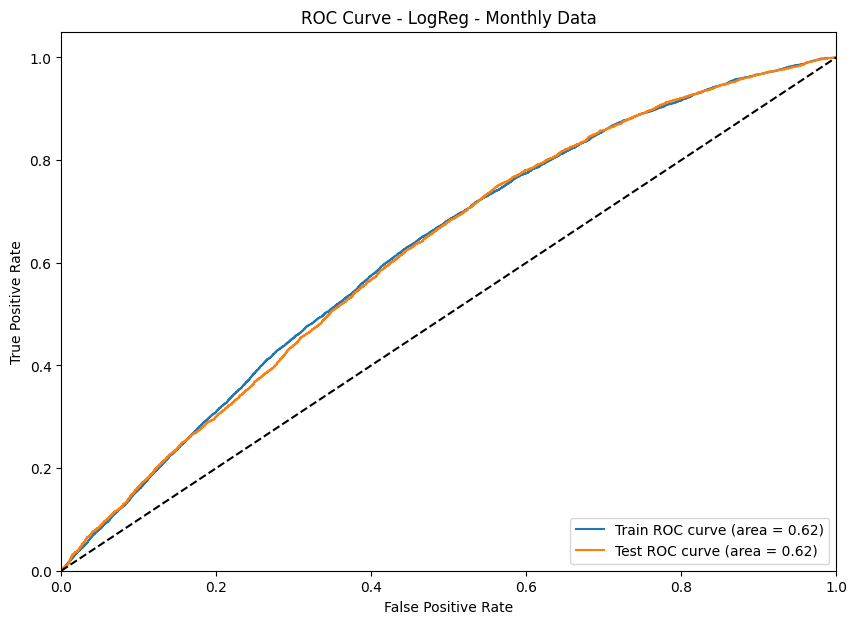

In [0]:
from pyspark.sql.functions import col, lit
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrainLogRegMon.select("probability", "response").toPandas()
pdPredTest = predTestLogRegMon.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg - Monthly Data')
plt.legend(loc="lower right")
plt.show()


#####Precision and Recall

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train
predictionAndLabels_train = predTrainLogRegMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTestLogRegMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Precision: 0.7985199224386536
Training Recall: 0.8935994194484761
Test Precision: 0.7934432995918477
Test Recall: 0.8907543430103766


##1.2.3 Decision Tree (Annual Data)

#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
dt = DecisionTreeClassifier(featuresCol = "scaled_features",labelCol = 'response')

paramGrid_dt = (ParamGridBuilder()
#                 .addGrid(dt.impurity, ["entropy","gini"])
                .addGrid(dt.maxDepth, [2, 5, 10, 20])
                .addGrid(dt.maxBins, [20, 32, 40]) 
                .build())

                
evaluator = BinaryClassificationEvaluator( labelCol="response", metricName="areaUnderROC")
 
# Create 5-fold CrossValidator
cv_dt = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid_dt,
                    evaluator=evaluator,
                    numFolds=5,  # Number of folds for cross-validation
                    parallelism=2)  # Evaluate up to 2 parameter settings in parallel

cvModel_dt = cv_dt.fit(X_train_annual) 
predTrain_dt=cvModel_dt.transform(X_train_annual)
predTest_dt=cvModel_dt.transform(X_test_annual)
bestModel_dt=cvModel_dt.bestModel
print(f"Best Model Params:\nMax Depth: {bestModel_dt.getMaxDepth()}\nMax Bins: {bestModel_dt.getMaxBins()}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model Params:
Max Depth: 5
Max Bins: 40


#####Feature Importance

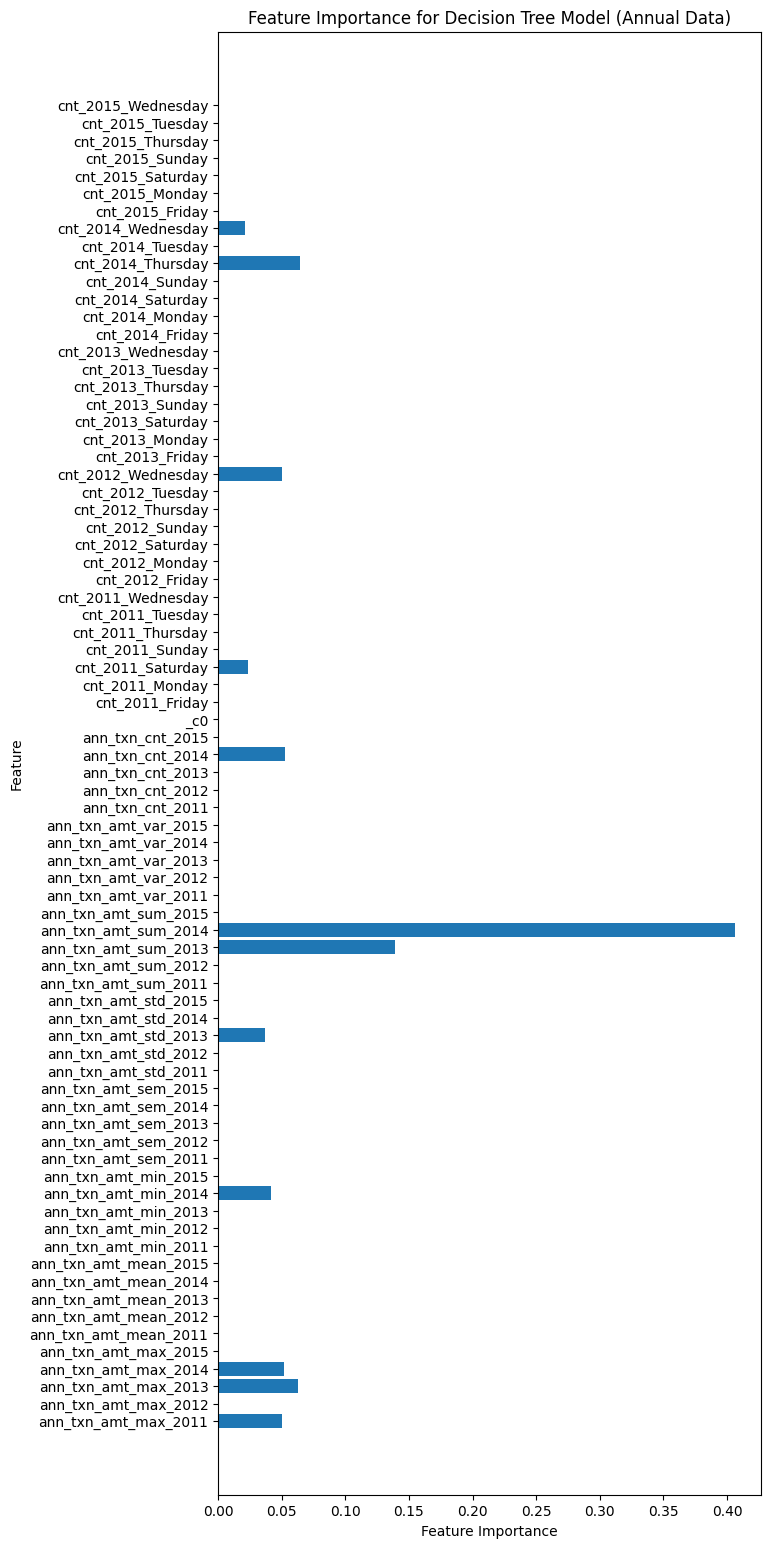

In [0]:
import matplotlib.pyplot as plt

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModel_dt.featureImportances.toArray()

# Plotting feature importance
plt.figure(figsize=(7, 19))
plt.barh(x_annual_colnames, coefficients)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Model (Annual Data)')
plt.show()

#####probability distribution for test set

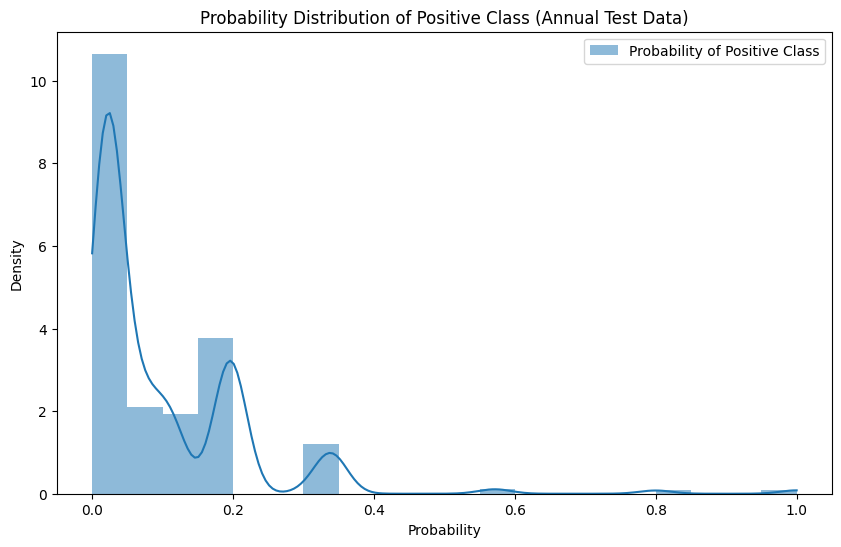

In [0]:
# plot probability distribution for test set

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract probabilities for the positive class
probabilities = predTest_dt.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Annual Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


#####Confusion Matrix 


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


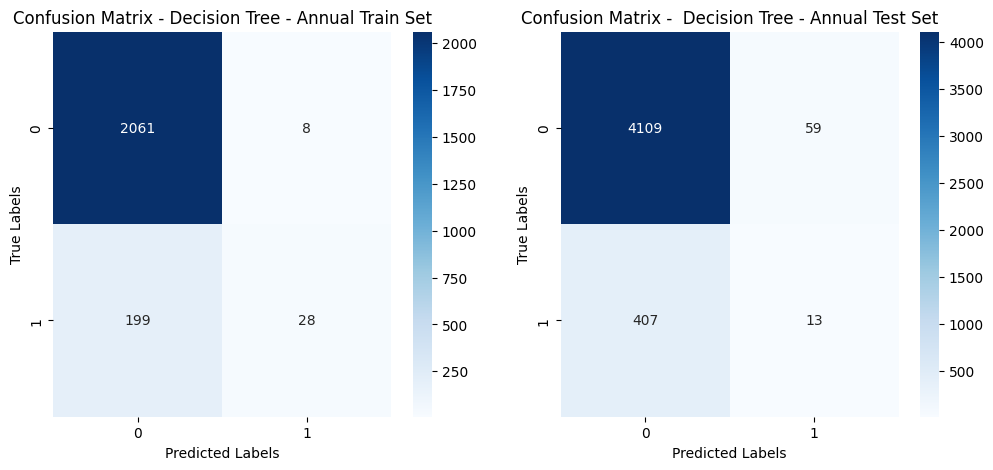

In [0]:
# Convert prediction and labels to RDD
predictionAndLabels_train = predTrain_dt.select("prediction", "response").rdd
predictionAndLabels_test = predTest_dt.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Decision Tree - Annual Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix -  Decision Tree - Annual Test Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()


#####ROC curve and AUC


Train Set AUC: 0.8066102716202894
Test Set AUC: 0.7091110844529751


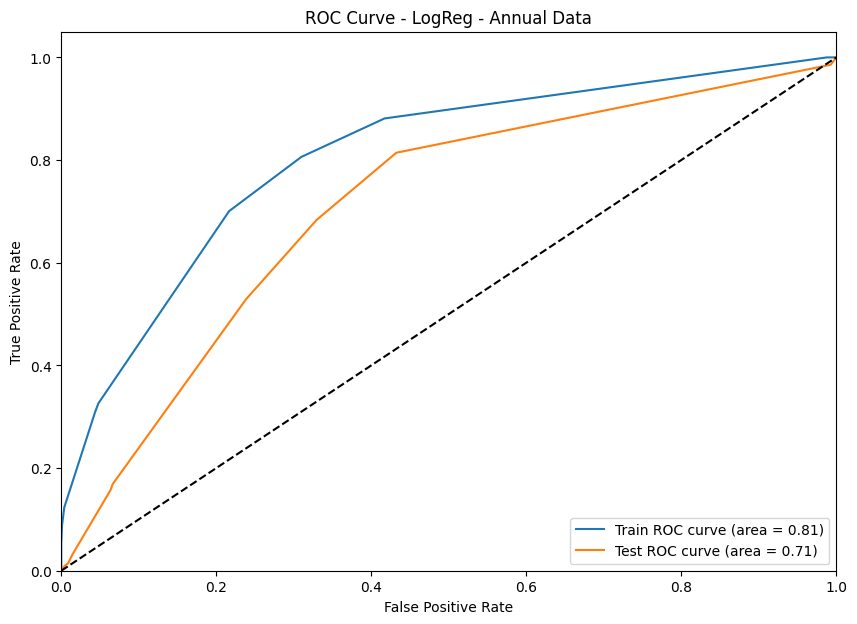

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Precision: 0.898681923845155
Training Recall: 0.9098432055749129
Test Precision: 0.8431117015183702
Test Recall: 0.8984306887532694


In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrain_dt)
auc_test = evaluator.evaluate(predTest_dt)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrain_dt.select("probability", "response").toPandas()
pdPredTest = predTest_dt.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg - Annual Data')
plt.legend(loc="lower right")
plt.show()


# Precision and Recall 
# Train
predictionAndLabels_train = predTrain_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTest_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")



##1.2.3 Decision Tree (Monthly Data)

In [0]:
dt = DecisionTreeClassifier(featuresCol = "scaled_features",labelCol = 'response')

paramGrid_dt = (ParamGridBuilder()
#                 .addGrid(dt.impurity, ["entropy","gini"])
                .addGrid(dt.maxDepth, [2, 5, 10, 20])
                .addGrid(dt.maxBins, [20, 32, 40]) 
                .build())

                
evaluator = BinaryClassificationEvaluator( labelCol="response", metricName="areaUnderROC")
 
# Create 5-fold CrossValidator
cv_dt = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid_dt,
                    evaluator=evaluator,
                    numFolds=5,  # Number of folds for cross-validation
                    parallelism=2)  # Evaluate up to 2 parameter settings in parallel

cvModel_dtMon = cv_dt.fit(X_train_monthly) 
predTrain_dtMon=cvModel_dtMon.transform(X_train_monthly)
predTest_dtMon=cvModel_dtMon.transform(X_test_monthly)
bestModel_dtMon=cvModel_dtMon.bestModel
print(f"Best Model Params:\nMax Depth: {bestModel_dtMon.getMaxDepth()}\nMax Bins: {bestModel_dtMon.getMaxBins()}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model Params:
Max Depth: 5
Max Bins: 40


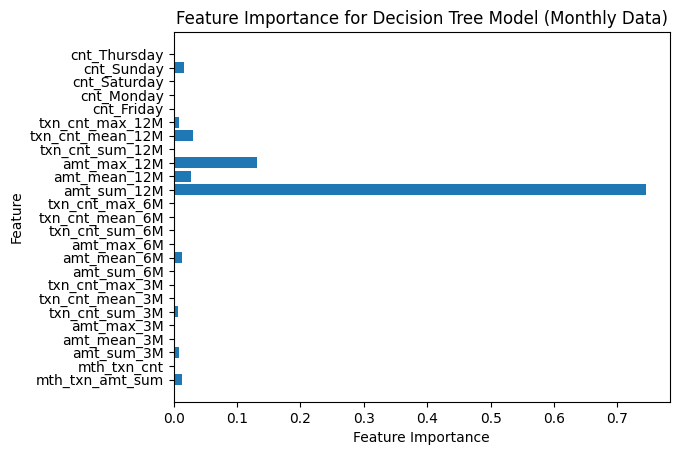

In [0]:
# Feature Importance 

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModel_dtMon.featureImportances.toArray()

# Plotting feature importance
plt.barh(x_mth_colnames, coefficients)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Model (Monthly Data)')
plt.show()

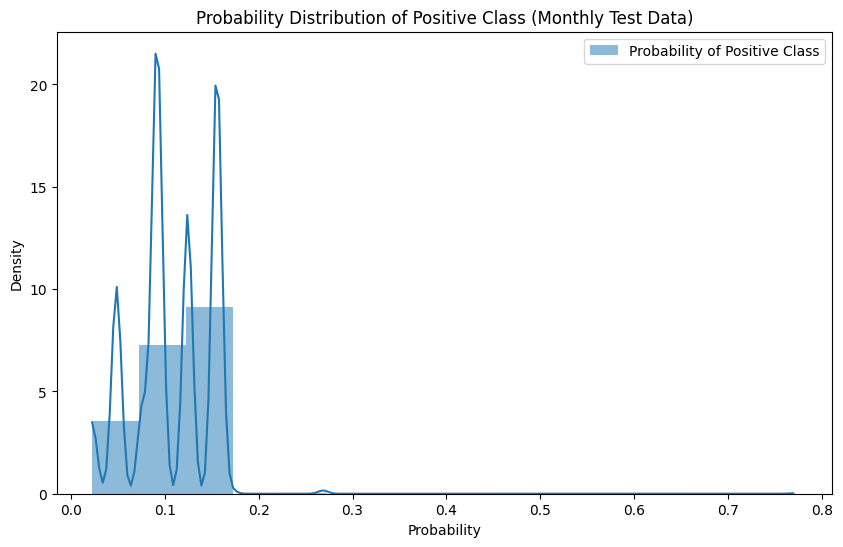

In [0]:
# plot probability distribution for test set

# Extract probabilities for the positive class
probabilities = predTest_dtMon.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Monthly Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


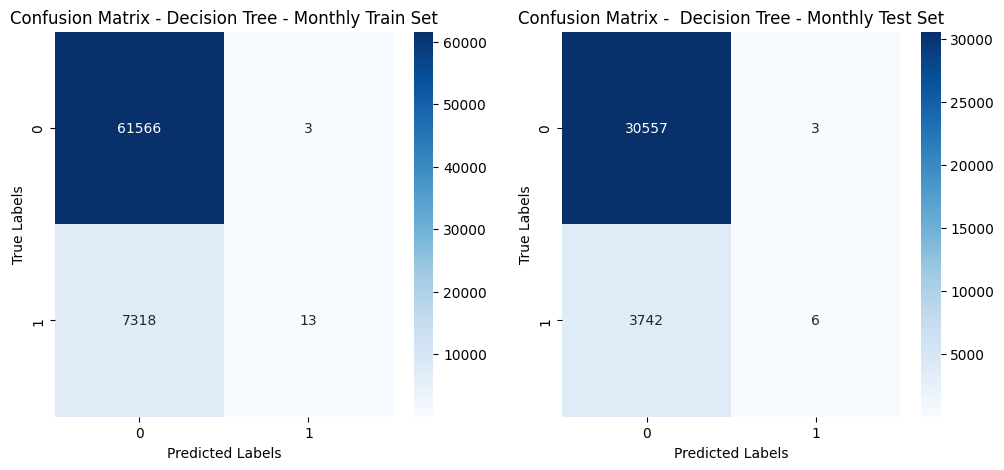

Train Set AUC: 0.6199853694483801
Test Set AUC: 0.6153234124517368


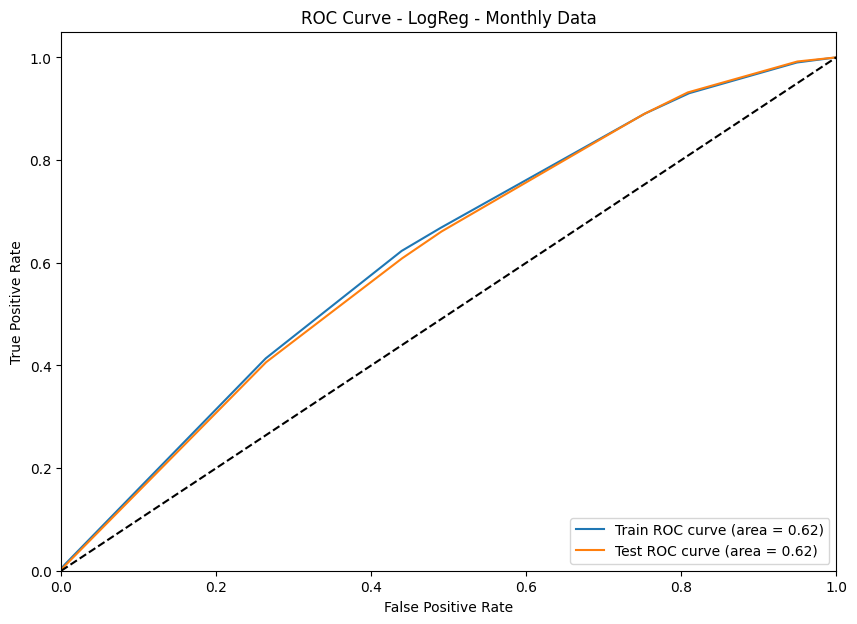

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Precision: 0.8851169524159124
Training Recall: 0.893744557329463
Test Precision: 0.8664040249597017
Test Recall: 0.8908417861723213


In [0]:

# Confusion Matrix

# Convert prediction and labels to RDD
predictionAndLabels_train = predTrain_dtMon.select("prediction", "response").rdd
predictionAndLabels_test = predTest_dtMon.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Decision Tree - Monthly Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix -  Decision Tree - Monthly Test Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrain_dtMon)
auc_test = evaluator.evaluate(predTest_dtMon)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrain_dtMon.select("probability", "response").toPandas()
pdPredTest = predTest_dtMon.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg - Monthly Data')
plt.legend(loc="lower right")
plt.show()


# Precision and Recall 
# Train
predictionAndLabels_train = predTrain_dtMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTest_dtMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")


##1.2.3 Random Forest (Annual Data)

In [0]:
rf = RandomForestClassifier(featuresCol = "scaled_features",labelCol = 'response')

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20]) 
                .addGrid(rf.maxDepth, [5, 10, 20]) 
                # .addGrid(rf.maxBins, [32, 48]) 
                # .addGrid(rf.impurity, ["gini", "entropy"]) \
                .build())

                
evaluator = BinaryClassificationEvaluator( labelCol="response", metricName="areaUnderROC")
 
# Create 5-fold CrossValidator
cv_rf = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=evaluator,
                    numFolds=5,  # Number of folds for cross-validation
                    parallelism=2)  # Evaluate up to 2 parameter settings in parallel

cvModel_rf = cv_rf.fit(X_train_annual) 
predTrain_rf=cvModel_rf.transform(X_train_annual)
predTest_rf=cvModel_rf.transform(X_test_annual)
bestModel_rf=cvModel_rf.bestModel
print(f"Best Model Params:\nNum Trees: {bestModel_rf.getNumTrees}\nMax Depth: {bestModel_rf.getMaxDepth()}\nMax Bins: {bestModel_rf.getMaxBins()}")



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model Params:
Num Trees: 20
Max Depth: 5
Max Bins: 32


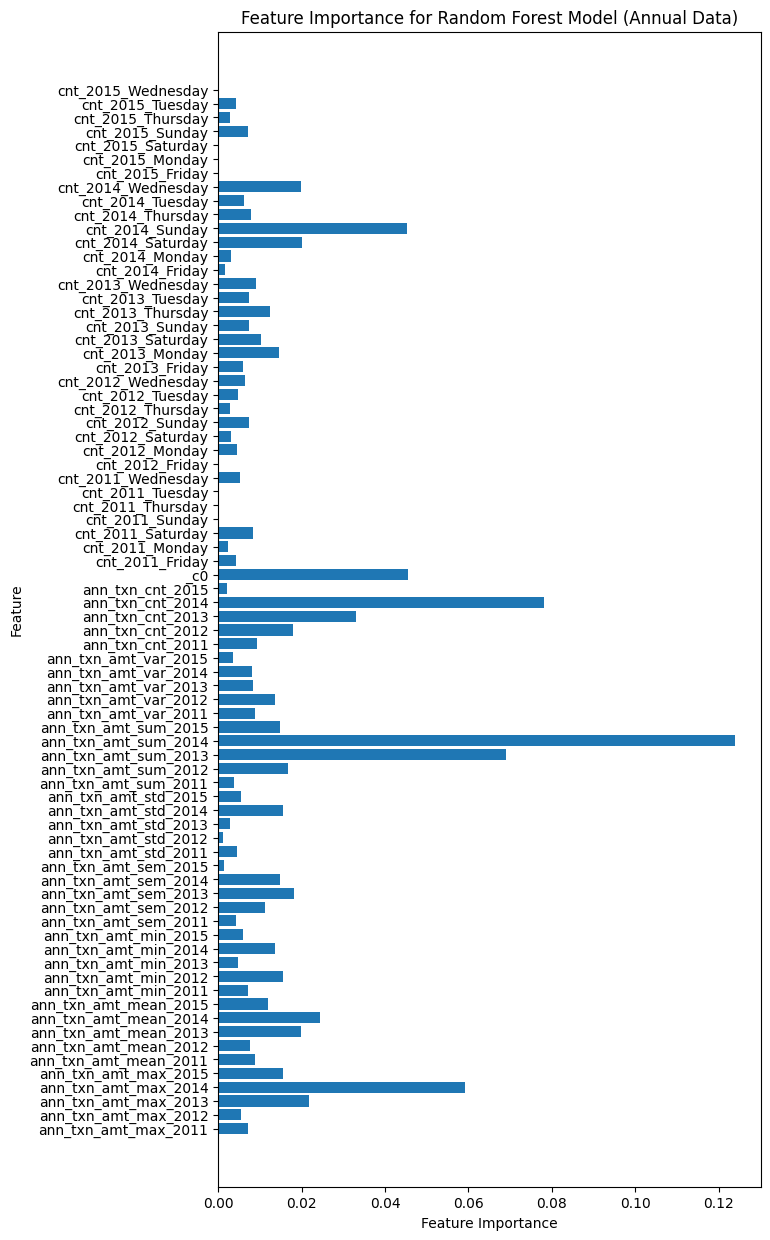

In [0]:
# Feature Importance 

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModel_rf.featureImportances.toArray()

# Plotting feature importance
plt.figure(figsize=(7,15))
plt.barh(x_annual_colnames, coefficients)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model (Annual Data)')
plt.show()

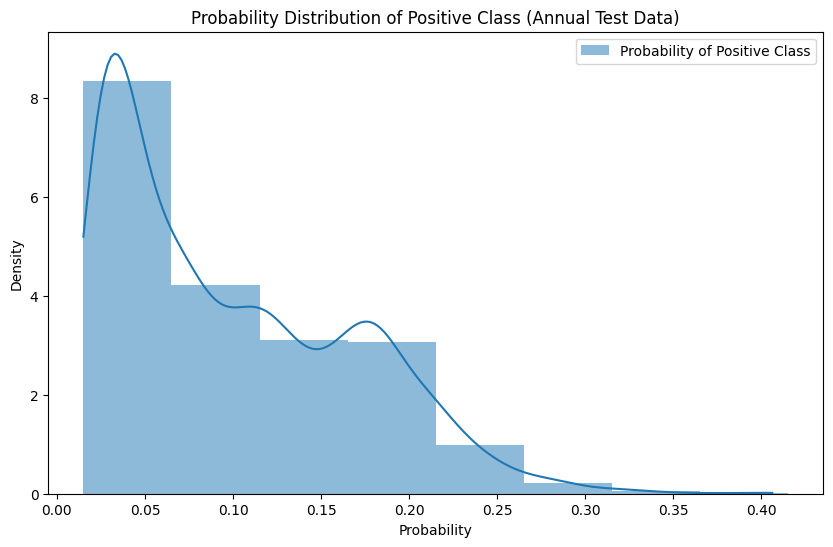

In [0]:
# plot probability distribution for test set

# Extract probabilities for the positive class
probabilities = predTest_rf.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Annual Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


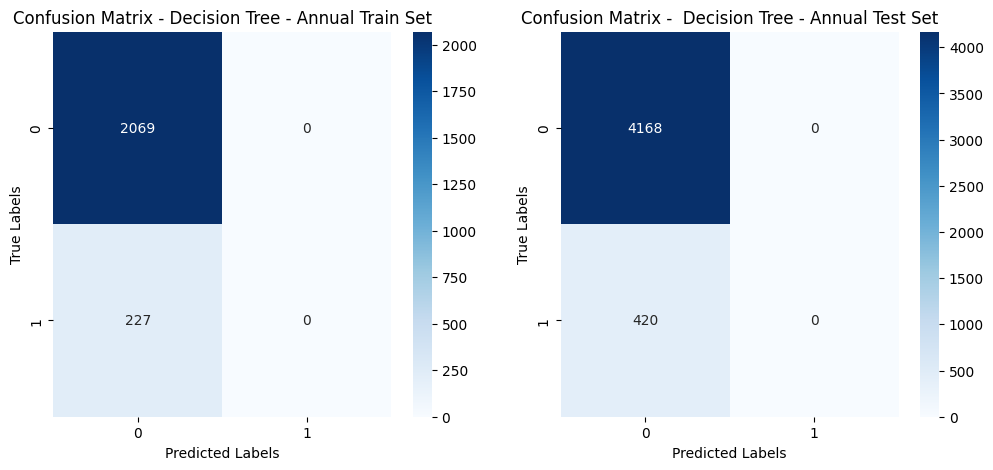

Train Set AUC: 0.9055471689275066
Test Set AUC: 0.7426840553879897


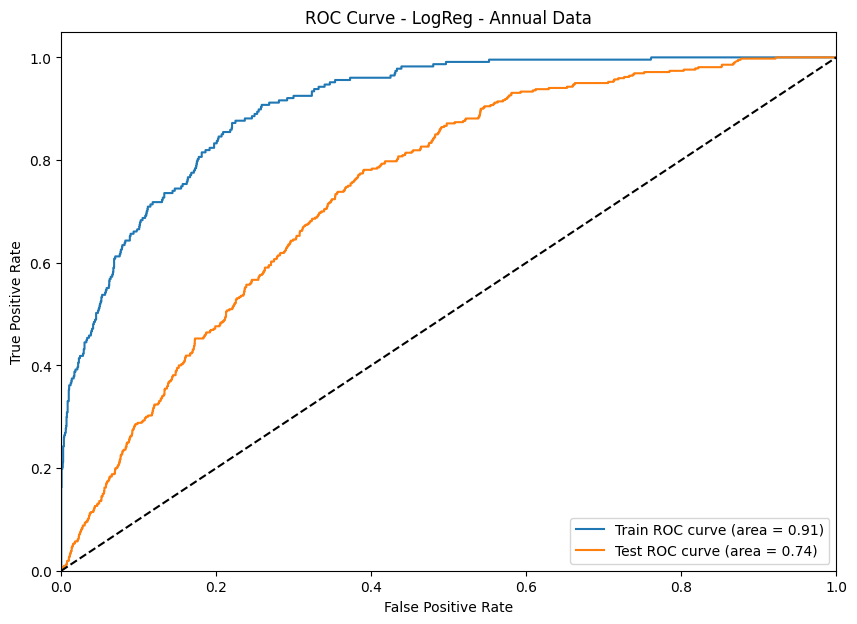

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Precision: 0.8120396098653619
Training Recall: 0.9011324041811847
Test Precision: 0.8252938373027244
Test Recall: 0.9084568439407149


In [0]:

# Confusion Matrix

# Convert prediction and labels to RDD
predictionAndLabels_train = predTrain_rf.select("prediction", "response").rdd
predictionAndLabels_test = predTest_rf.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Decision Tree - Annual Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix -  Decision Tree - Annual Test Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrain_rf)
auc_test = evaluator.evaluate(predTest_rf)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrain_rf.select("probability", "response").toPandas()
pdPredTest = predTest_rf.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg - Annual Data')
plt.legend(loc="lower right")
plt.show()


# Precision and Recall 
# Train
predictionAndLabels_train = predTrain_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTest_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")

##1.2.4 Random Forest (Monthly Data)

In [0]:
rf = RandomForestClassifier(featuresCol = "scaled_features",labelCol = 'response')

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20]) 
                .addGrid(rf.maxDepth, [5, 10, 20]) 
                # .addGrid(rf.maxBins, [32, 48]) 
                # .addGrid(rf.impurity, ["gini", "entropy"]) \
                .build())

                
evaluator = BinaryClassificationEvaluator( labelCol="response", metricName="areaUnderROC")
 
# Create 5-fold CrossValidator
cv_rf = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=evaluator,
                    numFolds=5,  # Number of folds for cross-validation
                    parallelism=2)  # Evaluate up to 2 parameter settings in parallel

cvModel_rfMon = cv_rf.fit(X_train_monthly) 
predTrain_rfMon=cvModel_rfMon.transform(X_train_monthly)
predTest_rfMon=cvModel_rfMon.transform(X_test_monthly)
bestModel_rfMon=cvModel_rfMon.bestModel
print(f"Best Model Params:\nNum Trees: {bestModel_rfMon.getNumTrees}\nMax Depth: {bestModel_rfMon.getMaxDepth()}")



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best Model Params:
Num Trees: 20
Max Depth: 5


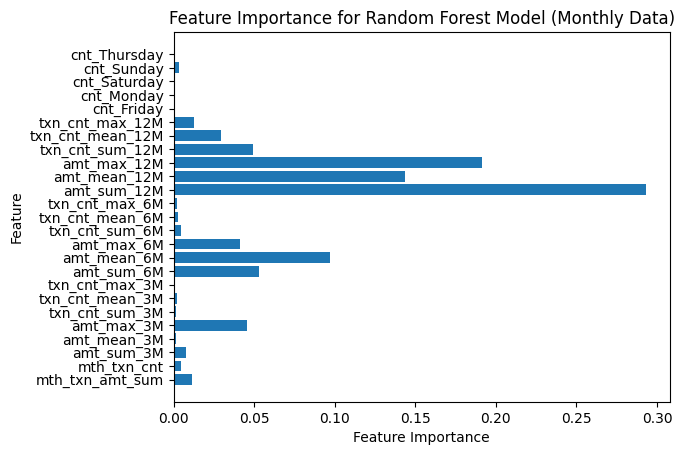

In [0]:
# Feature Importance 

# 5. Plot Feature Importance 
# Extract coefficients from the model
coefficients = bestModel_rfMon.featureImportances.toArray()

# Plotting feature importance
plt.barh(x_mth_colnames, coefficients)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model (Monthly Data)')
plt.show()

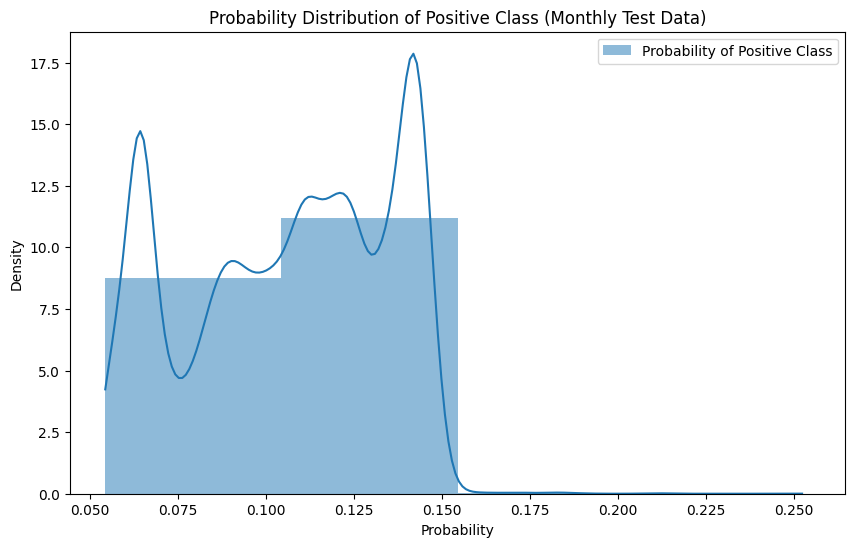

In [0]:
# plot probability distribution for test set

# Extract probabilities for the positive class
probabilities = predTest_rfMon.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Convert to Pandas DataFrame for easier plotting
pdf = pd.DataFrame(probabilities, columns=['Probability of Positive Class'])

# Plotting the probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(pdf, kde=True, stat="density", linewidth=0, binwidth=0.05)
plt.title('Probability Distribution of Positive Class (Monthly Test Data)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()


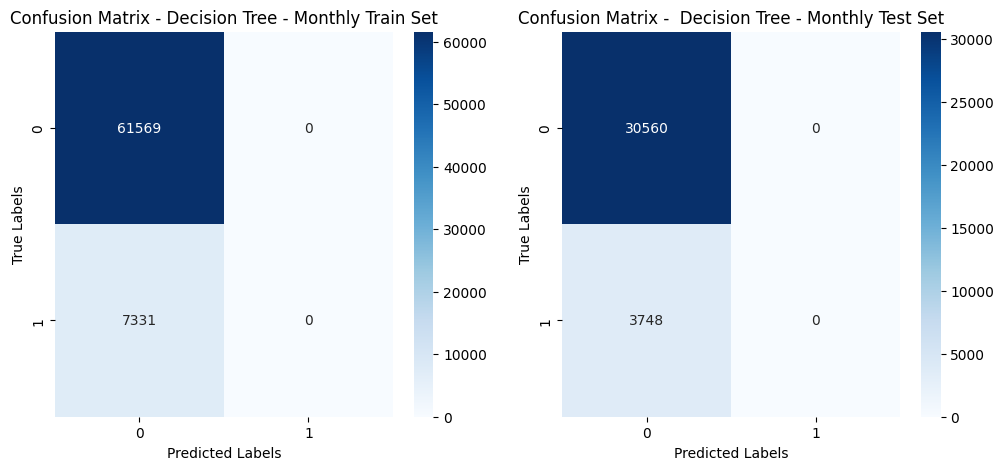

Train Set AUC: 0.6286322173636203
Test Set AUC: 0.6215062736775496


<Figure size 1000x700 with 1 Axes>

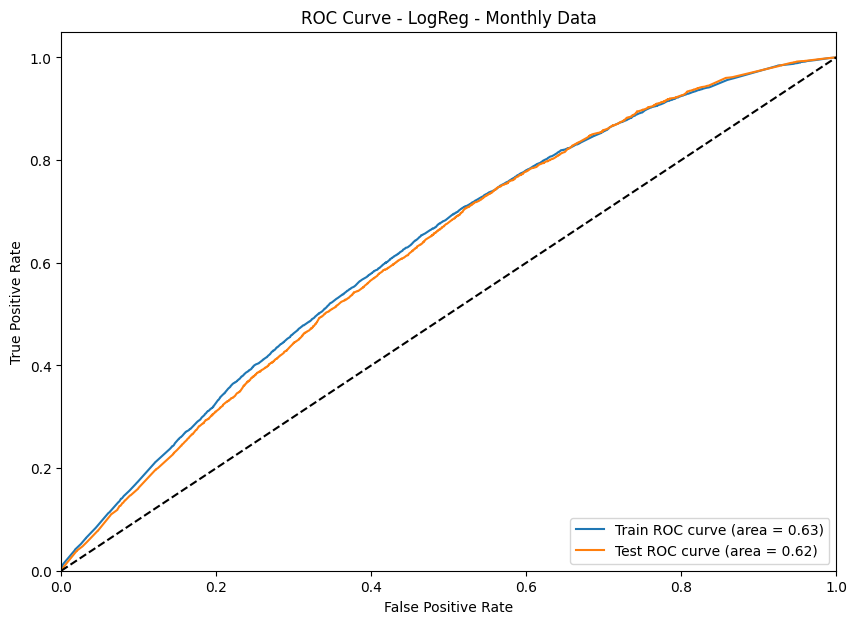

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Precision: 0.7985199224386536
Training Recall: 0.8935994194484761
Test Precision: 0.7934432995918477
Test Recall: 0.8907543430103766


In [0]:

# Confusion Matrix

# Convert prediction and labels to RDD
predictionAndLabels_train = predTrain_rfMon.select("prediction", "response").rdd
predictionAndLabels_test = predTest_rfMon.select("prediction", "response").rdd

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
confusionMatrix_train = metrics_train.confusionMatrix().toArray()
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusionMatrix_train, annot=True, fmt='g', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Decision Tree - Monthly Train Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(confusionMatrix_test, annot=True, fmt='g', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix -  Decision Tree - Monthly Test Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

evaluator = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="probability", metricName="areaUnderROC")

auc_train = evaluator.evaluate(predTrain_rfMon)
auc_test = evaluator.evaluate(predTest_rfMon)

print(f"Train Set AUC: {auc_train}")
print(f"Test Set AUC: {auc_test}")

# Convert Spark DataFrame to Pandas DataFrame for plotting 
# ensure this conversion is feasible with the dataset's size.
pdPredTrain = predTrain_rfMon.select("probability", "response").toPandas()
pdPredTest = predTest_rfMon.select("probability", "response").toPandas()

# Extract probabilities for the positive class 
train_prob = pdPredTrain['probability'].apply(lambda x: x[1]).values
test_prob = pdPredTest['probability'].apply(lambda x: x[1]).values

# True response
train_response = pdPredTrain['response']
test_response = pdPredTest['response']

# Calculate ROC curve and ROC area for both sets
fpr_train, tpr_train, _ = roc_curve(train_response, train_prob)
fpr_test, tpr_test, _ = roc_curve(test_response, test_prob)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg - Monthly Data')
plt.legend(loc="lower right")
plt.show()


# Precision and Recall 
# Train
predictionAndLabels_train = predTrain_rfMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_train = multi_metrics.weightedPrecision
recall_train = multi_metrics.weightedRecall

# Test
predictionAndLabels_train = predTest_rfMon.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precision_test = multi_metrics.weightedPrecision
recall_test = multi_metrics.weightedRecall

# Print the results
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")

#1.3 Model Comparison

| Model            | Time Frame | AUC_Train | AUC_Test | Weighted Average Precision_Test | Weighted Average Recall_Test|
|------------------|---------|-----------|----------|---------------------------------|------------------------------|
| Log Regression   | Annual  | 0.79                       | 0.77                    | 0.85                      | 0.90                      |
| Log Regression   | Monthly | 0.62                       | 0.61                    | 0.79                      | 0.89                      | 
| Decision Tree    | Annual  | 0.80                       | 0.70                    | 0.84                      | 0.89                      | 
| Decision Tree    | Monthly | 0.62                       | 0.62                    | 0.87                      | 0.89                      | 
| Random Forests   | Annual  | 0.91                       | 0.74                    | 0.82                      | 0.90                      | 
| Random Forests   | Monthly | 0.63                       | 0.62                    | 0.79                      | 0.89                      |


######Comparative Analysis:

AUC (Area Under the Curve):

Random Forests with Annual features has the highest AUC for both train (0.91) and test (0.74) datasets, indicating that it generalizes well and is the most effective in distinguishing between the classes.
Log Regression and Decision Tree with Monthly features have the lowest AUC, especially for the test set (0.61), which might suggest overfitting or less predictive power.
Precision and Recall:

Random Forests with Annual features again shows the best precision (0.82) and recall (0.90) for the test set, indicating a good balance between the two metrics, making it reliable for both identifying positive cases and not misclassifying negative cases.
Decision Tree with Monthly features has a higher precision for the test set (0.87) but lower AUC, which may mean it's precise when it predicts a positive class but may miss a number of actual positive cases.
Consistency Between Train and Test:

The Random Forests with Annual features show less discrepancy between training and test metrics, suggesting a model that's not overfitted and is more robust to unseen data.
The Log Regression model shows a significant drop from training to test AUC in both feature sets, suggesting possible overfitting.
Selection for Production:

######For deploying in a production environment, the Random Forests with Annual features combination seems to be the best choice due to the following reasons:

High AUC: AUC is a measure of the model's ability to distinguish between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. The Random Forest with Annual features has the highest AUC scores, suggesting it's more capable of classification tasks for both the training and test sets.

Balance of Precision and Recall: In a production environment, depending on the cost of false positives and false negatives, we might prioritize one over the other. However, without this information, a balance between precision and recall is usually preferred, and the Random Forest with Annual features provides this balance.

Generalizability: The performance drop from training to test is relatively moderate for the Random Forest with Annual features, indicating it generalizes well to new, unseen data.

Robustness: Random Forests are known for handling overfitting well, especially when there's sufficient data to train on. With the annual features likely capturing more general patterns without the noise that might come with more granular monthly data, the model is expected to be more robust.